# 🏋️ Model Training and Evaluation

## 📚 Overview

This is where the magic happens! You'll implement the **complete training loop** from scratch and learn:
- How neural networks actually learn (forward pass, loss, backward pass, optimization)
- Training vs. validation
- Monitoring training progress
- Evaluating model performance
- Preventing overfitting

## 🎯 Learning Objectives

By completing this notebook, you will:
1. **Implement a training loop** - the core of deep learning
2. **Understand backpropagation** - how gradients update weights
3. **Monitor training metrics** - loss, accuracy, validation performance
4. **Implement early stopping** - prevent overfitting
5. **Evaluate on validation set** - assess generalization
6. **Calculate classification metrics** - accuracy, precision, recall, F1
7. **Visualize training progress** - loss curves, accuracy plots

## 📋 Prerequisites

Before starting, ensure you've completed:
- ✅ `00_exploration.ipynb` - Data exploration
- ✅ `01_preprocessing.ipynb` - Text preprocessing
- ✅ `02_vocab_and_dataloader.ipynb` - Vocabulary and DataLoader
- ✅ `03_model_baseline.ipynb` - Model architecture

You should have:
- Model class defined
- DataLoaders ready (train + validation)
- Loss function and optimizer configured

---

## 🔄 The Training Loop Explained

### The Core Cycle:

```
For each epoch:
    For each batch in training data:
        1. Forward Pass: predictions = model(inputs)
        2. Calculate Loss: loss = loss_fn(predictions, targets)
        3. Backward Pass: loss.backward()  # Compute gradients
        4. Optimizer Step: optimizer.step()  # Update weights
        5. Zero Gradients: optimizer.zero_grad()  # Reset for next batch
        
    Validate on validation set
    Save best model
    Check for early stopping
```

### Key Concepts:
- **Epoch**: One complete pass through the training data
- **Batch**: A subset of data (e.g., 32 samples)
- **Forward Pass**: Input → Model → Output
- **Loss**: How wrong are the predictions?
- **Backward Pass**: Calculate gradients (how to improve)
- **Optimizer Step**: Update model parameters using gradients

---

## 🚀 Let's Train!


## TODO 1: Setup - Import Everything from Previous Notebooks 📦

**Goal**: Load all necessary components from your previous work.

**What you need**:
1. **Libraries**: torch, pandas, numpy, matplotlib, sklearn metrics
2. **Model**: Your DisasterTweetClassifier class
3. **Data**: Vocabulary, DataLoaders (train and validation)
4. **Config**: Hyperparameters, device, random seed

**Creating Train/Val Split**:
```python
# Load cleaned data
df = pd.read_csv('../data/interim/train_cleaned.csv')

# Split data (e.g., 80/20 or 90/10)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
```

**Important**: 
- Use `stratify=df['target']` to maintain class balance
- Create separate DataLoaders for train and validation
- Set `shuffle=True` for training, `shuffle=False` for validation

**Expected outcome**:
- Model, loss_fn, optimizer all initialized
- train_loader and val_loader ready
- Device set (CPU or GPU)


In [53]:
# TODO 1: Your code here
# Setup and imports
# Standard libraries
import sys
import os
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Copy/import your model class from notebook 03
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to path: {project_root}")
from src.models.baseline_model import DisasterTweetClassifier

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ========================
# 1. LOAD VOCABULARY
# ========================
print("Loading vocabulary...")
vocab_dict = pickle.load(open('../data/processed/vocab_dict.pkl', 'rb'))
vocab_size = len(vocab_dict)
print(f"✅ Vocabulary loaded: {vocab_size} words")

# ========================
# 2. LOAD CLEANED DATA
# ========================
print("Loading cleaned training data...")
cleaned_text = pd.read_csv("../data/interim/train_cleaned.csv")
print(f"✅ Loaded {len(cleaned_text)} training samples")

# ========================
# 3. RECREATE TEXT-TO-SEQUENCE FUNCTION (from notebook 02)
# ========================
def text_to_sequence(text, vocab_dict, max_length=50, pad_idx=0, unk_idx=1):
    """Convert text to sequence of indices."""
    words = text.lower().split()
    sequence = [vocab_dict.get(word, unk_idx) for word in words]
    
    if len(sequence) < max_length:
        sequence.extend([pad_idx] * (max_length - len(sequence)))
    else:
        sequence = sequence[:max_length]
    
    return sequence

# ========================
# 4. RECREATE DATASET CLASS (from notebook 02)
# ========================
class DisasterTweetsDataset(Dataset):
    def __init__(self, texts, labels, vocab_dict, max_length=50):
        self.texts = texts
        self.labels = labels
        self.vocab_dict = vocab_dict
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        return text, torch.tensor(label, dtype=torch.long)

# ========================
# 5. RECREATE COLLATE FUNCTION (from notebook 02)
# ========================
def collate_fn(batch, vocab_dict, max_length):
    texts, labels = zip(*batch)
    sequences = [text_to_sequence(text, vocab_dict, max_length) for text in texts]
    sequences = torch.tensor(sequences)
    return sequences, torch.tensor(labels)

# ========================
# 6. CREATE TRAIN/VAL SPLIT
# ========================
print("Creating train/validation split...")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    cleaned_text["text_clean"],
    cleaned_text["target"],
    test_size=0.2,
    random_state=42,
    stratify=cleaned_text["target"]  # Keep class balance!
)

print(f"✅ Train samples: {len(train_texts)}")
print(f"✅ Val samples: {len(val_texts)}")

# ========================
# 7. CREATE DATALOADERS
# ========================
print("Creating DataLoaders...")
train_loader = DataLoader(
    DisasterTweetsDataset(train_texts, train_labels, vocab_dict, max_length=50),
    batch_size=32,
    shuffle=True,  # Shuffle for training!
    collate_fn=lambda batch: collate_fn(batch, vocab_dict, max_length=50)
)

val_loader = DataLoader(
    DisasterTweetsDataset(val_texts, val_labels, vocab_dict, max_length=50),
    batch_size=32,
    shuffle=False,  # Don't shuffle validation!
    collate_fn=lambda batch: collate_fn(batch, vocab_dict, max_length=50)
)

print(f"✅ Train batches: {len(train_loader)}")
print(f"✅ Val batches: {len(val_loader)}")

# ========================
# 8. INITIALIZE MODEL
# ========================
print("Initializing model...")
embedding_dim = 50
hidden_dim = 64

model = DisasterTweetClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    padding_idx=0
)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model initialized with {total_params:,} trainable parameters")

# ========================
# 9. SETUP LOSS AND OPTIMIZER
# ========================
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("\n" + "="*50)
print("SETUP COMPLETE - READY FOR TRAINING!")
print("="*50)
print(f"Device: {device}")
print(f"Vocabulary size: {vocab_size}")
print(f"Model parameters: {total_params:,}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print("="*50)

Using device: cpu
Loading vocabulary...
✅ Vocabulary loaded: 14646 words
Loading cleaned training data...
✅ Loaded 7613 training samples
Creating train/validation split...
✅ Train samples: 6090
✅ Val samples: 1523
Creating DataLoaders...
✅ Train batches: 191
✅ Val batches: 48
Initializing model...
✅ Model initialized with 735,629 trainable parameters

SETUP COMPLETE - READY FOR TRAINING!
Device: cpu
Vocabulary size: 14646
Model parameters: 735,629
Train batches: 191
Val batches: 48


## TODO 2: Implement Training Function for One Epoch 🔄

**Goal**: Write a function that trains the model for one complete epoch.

**Function Structure**:
```python
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()  # Set to training mode
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in dataloader:
        # Get data
        # Move to device
        # Forward pass
        # Calculate loss
        # Backward pass
        # Optimizer step
        # Track metrics
    
    return avg_loss, accuracy
```

**Key Steps in Loop**:
1. `model.train()` - Enable dropout, batch norm training mode
2. Get texts and labels from batch
3. Move tensors to device
4. Zero gradients: `optimizer.zero_grad()`
5. Forward pass: `outputs = model(texts)`
6. Calculate loss: `loss = loss_fn(outputs, labels)`
7. Backward pass: `loss.backward()`
8. Update weights: `optimizer.step()`
9. Track loss and accuracy

**Accuracy Calculation**:
```python
# Convert logits to predictions (0 or 1)
predictions = (torch.sigmoid(outputs) > 0.5).float()
correct += (predictions == labels).sum().item()
```

**Hints**:
- Accumulate loss: `total_loss += loss.item()`
- Track number of samples: `total += labels.size(0)`
- Return average loss: `total_loss / len(dataloader)`
- Return accuracy: `correct / total`


In [54]:
# TODO 2: Your code here
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    """Train model for one epoch."""
    # TODO: Set model to training mode
    model.train()

    
    # TODO: Initialize tracking variables
    total_loss = 0
    correct = 0
    total = 0
    # TODO: Loop through batches
    for batch in dataloader:
    # for texts, labels in dataloader:
        for texts, labels in dataloader:
        # TODO: Move to device
            texts = texts.to(device)
            labels = labels.to(device).float()
        # TODO: Zero gradients
            optimizer.zero_grad()
        # TODO: Forward pass
            outputs = model(texts).squeeze()
        # TODO: Calculate loss
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * texts.size(0)
        # TODO: Backward pass
            loss.backward()
        # TODO: Optimizer step
            optimizer.step()
        # TODO: Track metrics
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()
            total += labels.size(0)  
    # TODO: Calculate and return average metrics
    # return avg_loss, accuracy
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


## TODO 3: Implement Validation Function 📊

**Goal**: Evaluate model on validation set (no gradient updates).

**Key Difference from Training**:
- `model.eval()` - Disable dropout, use batch norm in eval mode
- `torch.no_grad()` - Don't track gradients (saves memory, faster)
- No `backward()` or `optimizer.step()`

**Function Structure**:
```python
def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Don't track gradients
        for texts, labels in dataloader:
            # Move to device
            # Forward pass only
            # Calculate loss and accuracy
            
    return avg_loss, accuracy
```

**Why validation?**:
- Check if model generalizes to unseen data
- Detect overfitting (train acc high, val acc low)
- Decide when to stop training

---



In [55]:
# TODO 3: Your code here
def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for texts, labels in dataloader:
            texts = texts.to(device)
            labels = labels.to(device).float()

            outputs = model(texts).squeeze()
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * texts.size(0)

            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

## TODO 4: Implement Complete Training Loop 🔁

**Goal**: Train for multiple epochs with validation and progress tracking.

**Structure**:
```python
def train_model(model, train_loader, val_loader, loss_fn, optimizer, 
                num_epochs, device):
    history = {'train_loss': [], 'train_acc': [], 
               'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_acc = train_one_epoch(...)
        
        # Validate
        val_loss, val_acc = validate(...)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        # ... store others
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
        
        # Optional: Save best model, early stopping
        
    return history
```

**Number of Epochs**: Start with 10-20, adjust based on convergence

---




In [56]:
#TODO 4: Your code here- Training Loop

num_epochs = 6
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs):
    history = {'train_loss': [], 'train_acc': [],'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-"*30)
    
    return history



## TODO 5: Train Your Model 🚀

Execute the training! Monitor for:
- **Loss decreasing** - Model is learning
- **Accuracy increasing** - Predictions improving  
- **Val metrics similar to train** - Good generalization
- **Val metrics much worse than train** - Overfitting! Stop or regularize

---



In [57]:
# TODO 5: execute training
print("Starting training...")
history = train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs)
print("Training complete!")


Starting training...
Epoch 1/6
Train Loss: 0.6835, Train Acc: 0.5517
Val Loss: 0.6720, Val Acc: 0.5726
------------------------------
Epoch 2/6
Train Loss: 0.6446, Train Acc: 0.6381
Val Loss: 0.5955, Val Acc: 0.7262
------------------------------
Epoch 3/6
Train Loss: 0.5048, Train Acc: 0.7814
Val Loss: 0.4825, Val Acc: 0.7702
------------------------------
Epoch 4/6
Train Loss: 0.3575, Train Acc: 0.8573
Val Loss: 0.4545, Val Acc: 0.7938
------------------------------
Epoch 5/6
Train Loss: 0.2523, Train Acc: 0.9080
Val Loss: 0.4687, Val Acc: 0.7984
------------------------------
Epoch 6/6
Train Loss: 0.2054, Train Acc: 0.9301
Val Loss: 0.4716, Val Acc: 0.7978
------------------------------
Training complete!


## TODO 6: Evaluate and Calculate Metrics 📈

Calculate detailed classification metrics:
- **Accuracy**: Overall correctness
- **Precision**: Of predicted disasters, how many are real?
- **Recall**: Of real disasters, how many did we catch?
- **F1-Score**: Harmonic mean of precision and recall (competition metric!)
- **Confusion Matrix**: Visualize true/false positives/negatives

```python
from sklearn.metrics import classification_report, confusion_matrix
# Get predictions on validation set
# Calculate metrics
```

---


In [61]:
# TODO 6: Evaluation and metrics
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for texts, labels in val_loader:
        texts = texts.to(device)
        labels = labels.to(device).float()

        outputs = model(texts).squeeze()
        preds = torch.round(torch.sigmoid(outputs))

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

        
accuracy = history['val_acc'][-1]
print(f"Final Validation Accuracy: {accuracy:.4f}")
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Final Validation Accuracy: 0.7978
Precision: 0.7808, Recall: 0.7355, F1-Score: 0.7575



## TODO 7: Visualize Training Progress 📊

Create plots to understand training:
1. **Loss curves**: Train vs. Val loss over epochs
2. **Accuracy curves**: Train vs. Val accuracy over epochs
3. **Confusion matrix**: Heatmap of predictions

---



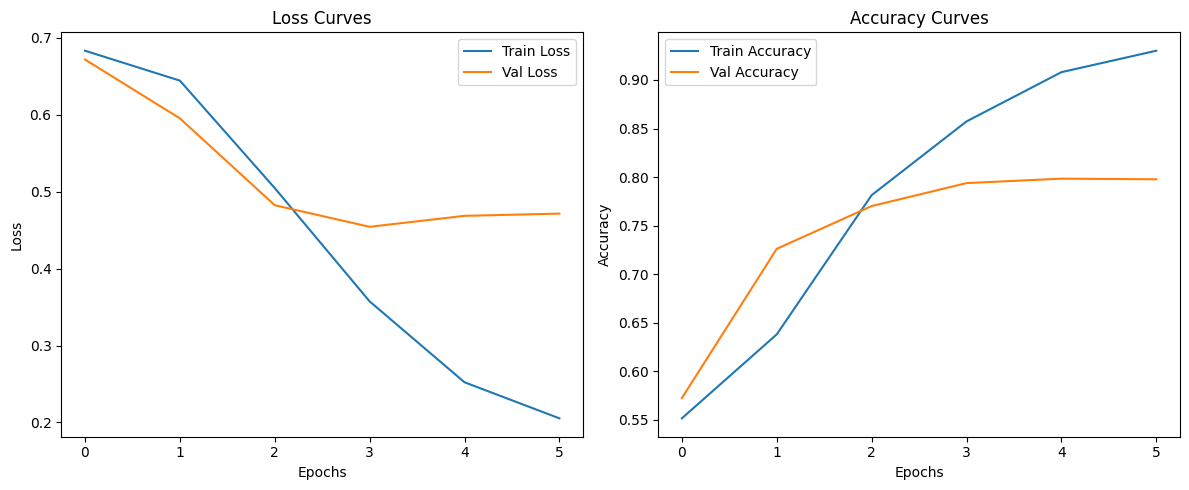

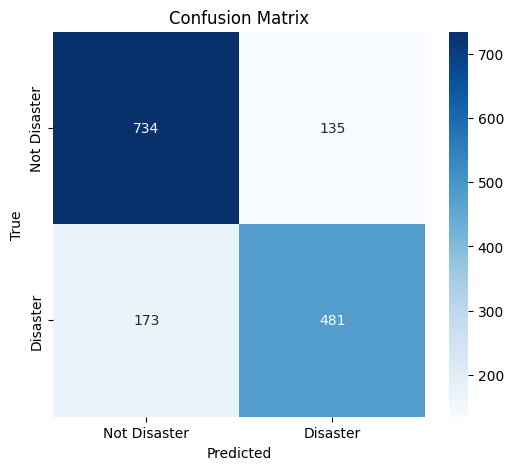

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.81      0.84      0.83       869
    Disaster       0.78      0.74      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [62]:
# Visualize loss curves, accuracy curves, confusion matrix
# Loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()


# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Not Disaster', 'Disaster']))


## TODO 8: Save Your Trained Model 💾

Save the model for inference and submission:
```python
torch.save(model.state_dict(), '../models/disaster_classifier.pth')
torch.save(history, '../models/training_history.pkl')
```

In [60]:
# Save the trained model
model_path = '../src/models/disaster_tweet_classifier.pth'
torch.save(model.state_dict(), model_path)
torch.save(history, '../src/models/training_history.pkl')
print(f"Model saved to {model_path}")

Model saved to ../src/models/disaster_tweet_classifier.pth
